In [93]:
#-- Descomprimimos el dataset
# !rm -r mnist
# !unzip mnist.zip

# **PUNTO 1. **

Obtenga las curvas de los score loss, f1_score y accuracy para los sets de entrenamiento y validación usando diferentes tamaños del set de entrenamiento (10%, 20%, 50%, 80% y 100%) cuando el conjunto de validación es completo [30pts]. i) Indique cuál es la importancia del tamaño del conjunto de entrenamiento ii) Compare las curvas de entrenamiento y validación usando los 3 scores y iii) haga un breve análisis de los resultado obtenidos [15pts].

# CASO BASE: 100% DE LOS DATOS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

train_files[0]

'./mnist/train/0/3565.png'

In [3]:
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

In [4]:
#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [5]:
#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [6]:
#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

In [7]:
#--- Visualizamos el tamaño de cada subset
len(X_train), len(X_valid), len(X_test)

(6000, 2000, 992)

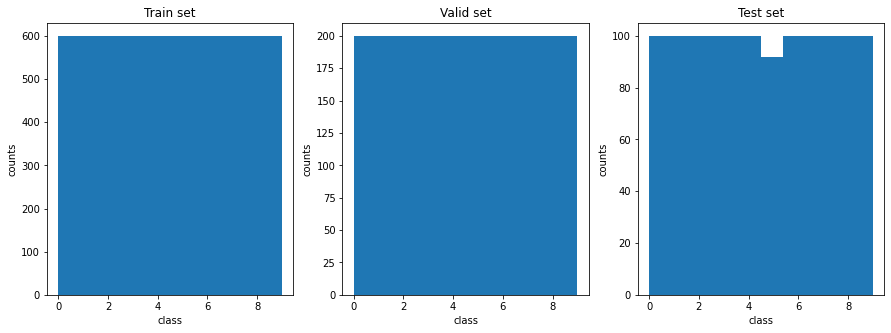

In [8]:
#--- Visualizamos la distribución de clases en cada subset
from PIL import Image
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(np.sort(Y_train))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Train set')

plt.subplot(1,3,2)
plt.hist(np.sort(Y_valid))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Valid set')

plt.subplot(1,3,3)
plt.hist(np.sort(Y_test))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Test set')

plt.show()

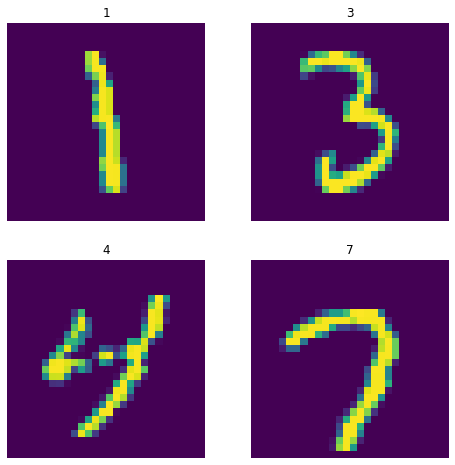

In [9]:
#-- Visualizamos los datos
fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [10]:
#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

In [11]:
#--- Definimos una ANN con dos capas ocultas lineales de 100 neuronas

input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [12]:
from sklearn.metrics import f1_score # Nueva métrica (La revisaremos la próóxima sesión)

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)


Epoch [1/100], loss: 11.168167114257812. f1:0.07519009891228408 acc: 0.11233333498239517 
Epoch [2/100], loss: 7.040389537811279. f1:0.1082564040802562 acc: 0.13766667246818542 
Epoch [3/100], loss: 5.1656951904296875. f1:0.1776426762088655 acc: 0.20483332872390747 
Epoch [4/100], loss: 4.068375110626221. f1:0.2433898461699915 acc: 0.2783333361148834 
Epoch [5/100], loss: 3.1598050594329834. f1:0.32448392754606714 acc: 0.3641666769981384 
Epoch [6/100], loss: 2.651906967163086. f1:0.3819779982670648 acc: 0.42899999022483826 
Epoch [7/100], loss: 2.338852882385254. f1:0.41694837472743806 acc: 0.47066667675971985 
Epoch [8/100], loss: 2.072265863418579. f1:0.4444712788117714 acc: 0.5011666417121887 
Epoch [9/100], loss: 1.865830898284912. f1:0.46699650769403644 acc: 0.5213333368301392 
Epoch [10/100], loss: 1.7037888765335083. f1:0.49256736895201686 acc: 0.5388333201408386 
Epoch [11/100], loss: 1.5332379341125488. f1:0.5377247014403217 acc: 0.5705000162124634 
Epoch [12/100], loss: 1.36

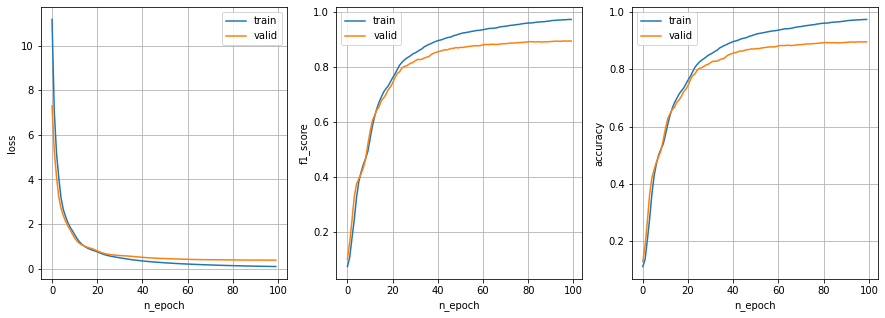

In [13]:

#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [14]:
#-- Evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.33839091658592224, f1: 0.9060380398129677, acc: 0.90625


# CASO #2: 80% DE LOS DATOS

In [15]:
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

type(train_files)
# Como se busca hacerlo para el 80% de los datos de entrenamiento, entonces se tomarán los datos hasta el 4800.
train_files2 = train_files[0:4800]
len(train_files2)

4800

In [16]:
np.random.shuffle(train_files2)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files2), len(valid_files), len(test_files)

(4800, 2000, 992)

In [17]:
N_train = len(train_files2)
X_train = []
Y_train = []

for i, train_file2 in enumerate(train_files2):
  Y_train.append( int(train_file2.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file2)))

In [18]:
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [19]:
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

In [20]:
len(X_train), len(X_valid), len(X_test)

(4800, 2000, 992)

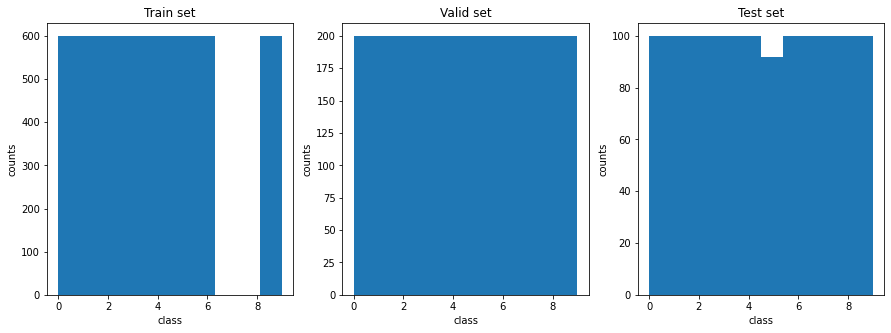

In [21]:
from PIL import Image
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(np.sort(Y_train))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Train set')

plt.subplot(1,3,2)
plt.hist(np.sort(Y_valid))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Valid set')

plt.subplot(1,3,3)
plt.hist(np.sort(Y_test))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Test set')

plt.show()

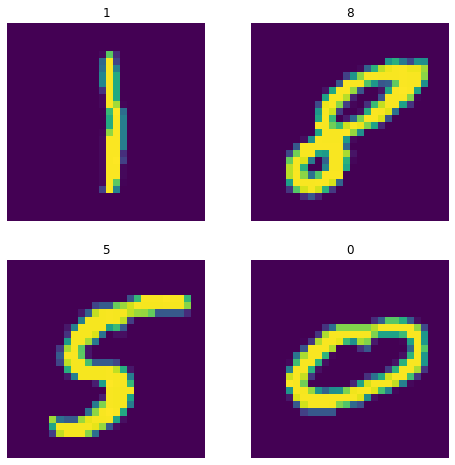

In [22]:
fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [23]:
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([4800, 28, 28])

In [24]:
input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [25]:
n_epoch = 100

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)


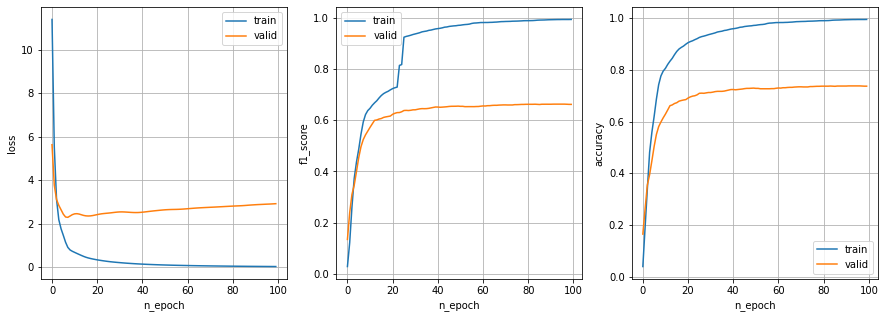

In [26]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [27]:
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 3.1135504245758057, f1: 0.6614722751135741, acc: 0.7338709831237793


# CASO 3: 50% DE LOS DATOS

In [28]:
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

type(train_files)
# De igual forma que en el caso anterior, se tomará ahora el 50% de los datos que se encuentran en el conjunto incial. 
train_files3 = train_files[0:3000]
len(train_files3)

3000

In [29]:
np.random.shuffle(train_files3)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files3), len(valid_files), len(test_files)

(3000, 2000, 992)

In [30]:
N_train = len(train_files3)
X_train = []
Y_train = []

for i, train_file3 in enumerate(train_files3):
  Y_train.append( int(train_file3.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file3)))

In [31]:
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)))

In [32]:
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

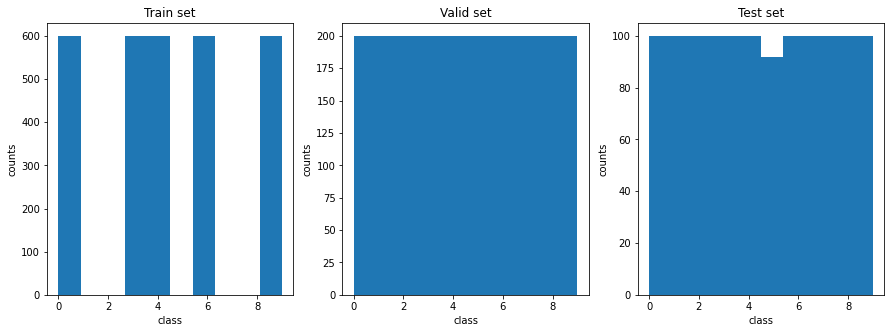

In [33]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(np.sort(Y_train))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Train set')

plt.subplot(1,3,2)
plt.hist(np.sort(Y_valid))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Valid set')

plt.subplot(1,3,3)
plt.hist(np.sort(Y_test))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Test set')

plt.show()

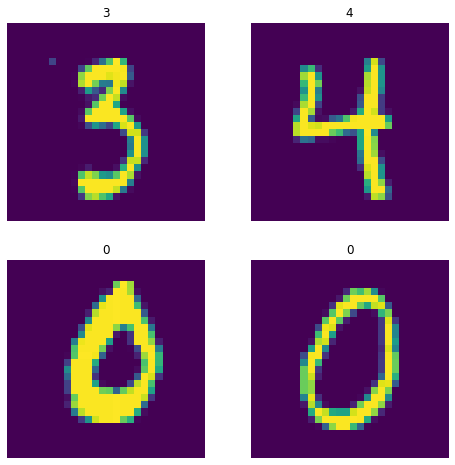

In [34]:
fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [35]:
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([3000, 28, 28])

In [36]:
input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [37]:
n_epoch = 100

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)


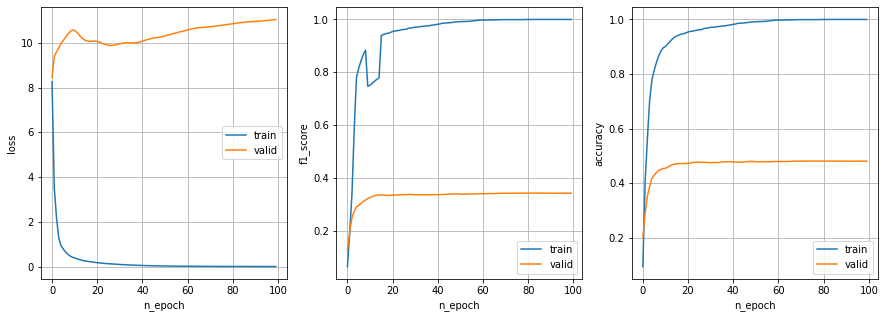

In [38]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [39]:
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 11.271595001220703, f1: 0.34296290319072104, acc: 0.4838709533214569


# CASO 4: 20% DE LOS DATOS

In [40]:
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

type(train_files)
# De igual forma que en el caso anterior, se tomará ahora el 20% de los datos que se encuentran en el conjunto incial. 
train_files4 = train_files[0:1200]
len(train_files4)

1200

In [41]:
np.random.shuffle(train_files4)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files4), len(valid_files), len(test_files)

(1200, 2000, 992)

In [42]:
N_train = len(train_files4)
X_train = []
Y_train = []

for i, train_file4 in enumerate(train_files4):
  Y_train.append( int(train_file4.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file4)))

In [43]:
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)))

In [44]:
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

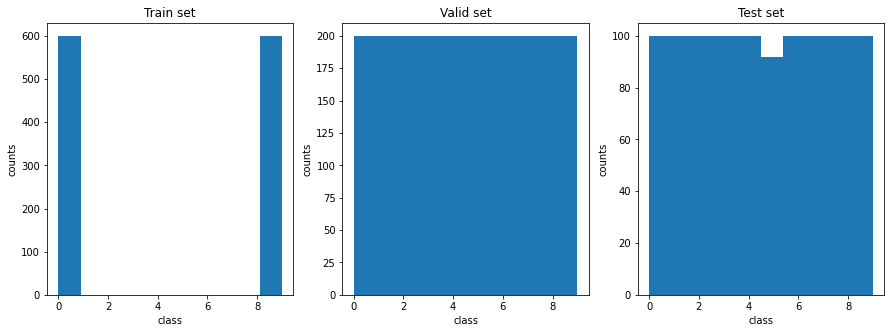

In [45]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(np.sort(Y_train))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Train set')

plt.subplot(1,3,2)
plt.hist(np.sort(Y_valid))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Valid set')

plt.subplot(1,3,3)
plt.hist(np.sort(Y_test))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Test set')

plt.show()

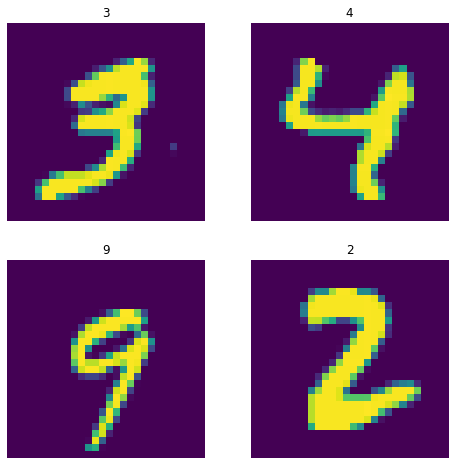

In [46]:
fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [47]:
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([1200, 28, 28])

In [48]:
input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [49]:
n_epoch = 100

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

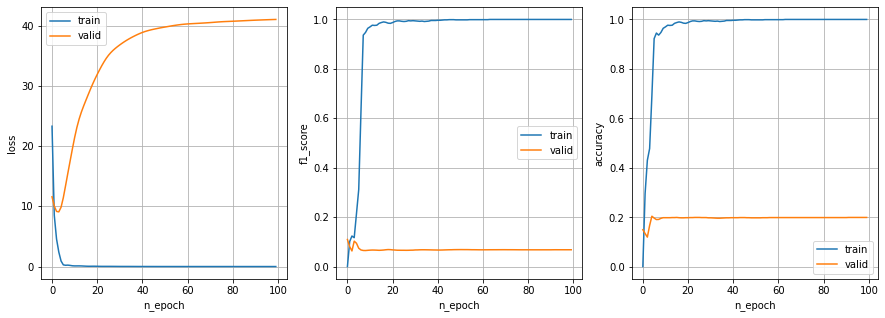

In [50]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [51]:
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 41.02837371826172, f1: 0.0690184271094191, acc: 0.2016129046678543


# CASO 5: 10% DE LOS DATOS

In [52]:
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

type(train_files)
# De igual forma que en el caso anterior, se tomará ahora el 10% de los datos que se encuentran en el conjunto incial. 
train_files5 = train_files[0:600]
len(train_files5)

600

In [53]:
np.random.shuffle(train_files5)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files5), len(valid_files), len(test_files)

(600, 2000, 992)

In [54]:
N_train = len(train_files5)
X_train = []
Y_train = []

for i, train_file5 in enumerate(train_files5):
  Y_train.append( int(train_file5.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file5)))

In [55]:
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)))

In [56]:
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

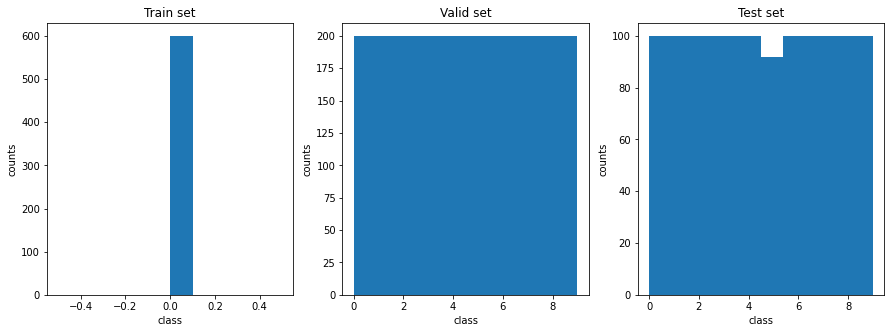

In [57]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(np.sort(Y_train))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Train set')

plt.subplot(1,3,2)
plt.hist(np.sort(Y_valid))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Valid set')

plt.subplot(1,3,3)
plt.hist(np.sort(Y_test))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Test set')

plt.show()

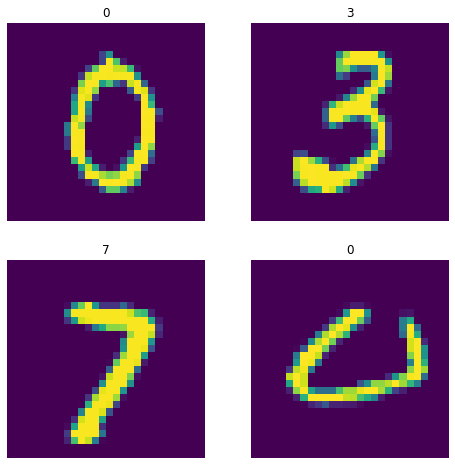

In [58]:
fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [59]:
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([600, 28, 28])

In [60]:
input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [61]:
n_epoch = 100

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

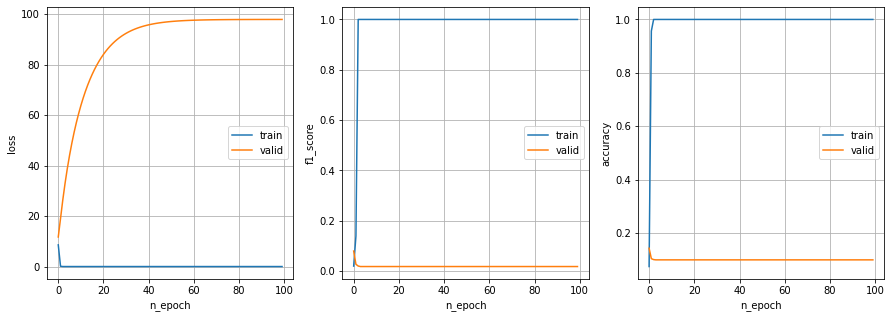

In [62]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [63]:
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 99.9427719116211, f1: 0.018315018315018312, acc: 0.10080645233392715


## **ANÁLISIS**

De los resultados obtenidos para el accuracy, lo cual indica qué tan adecuado fue el modelo, se puede decir que a medida que se disminuye la cantidad de datos en el entrenamiento, este disminuye. Esto correspondería con el comportamiento esperado ya que al tener menor cantidad de datos para entrenamiento, el algoritmo no está listo para poder hacer una clasificación correcta de las imágenes del conjunto de datos. La importancia del conjunto de entrenamiento radica en que estos datos son necesarios para preparar al algoritmo en la tarea que se le está ordenando ya que, de no ser suficientes datos, como se mostró anteriormente, la respuesta no sería la adecuada. 

Por otro lado, de las curvas obtenidas, se puede decir que a medida que se disminuía el número de datos en el conjunto de entrenamiento, aumenta la brecha existente entre los datos de entrenamiento y los de validación, lo cual, nuevamente, es un indicativo de que el algoritmo, al suprimir datos de entrenamiento, opera de forma cada vez más ineficiente.

# **PUNTO 2. **

Para un modelo entrenado con el 100% de los datos de entrenamiento y 100% validación pruebe diferentes tamaños del conjunto de testeo para evaluar (10%, 20%, 50%, 80% y 100%) e imprima los 3 scores en cada caso [30pts]. i) Indique cuál es la importancia del tamaño del conjunto de testeo ii) Compare los score obtenidos en cada caso y iii) haga un breve análisis de los resultado obtenidos [15pts].

# CASO BASE: 100% DE LOS DATOS

El caso base, para este punto, corresponde al mismo caso base del punto anterior. 

# CASO 2: 80% DE LOS DATOS

In [64]:
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

test_files2 = test_files[0:794]
len(test_files2)

794

In [65]:
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files2)

len(train_files), len(valid_files), len(test_files2)

(6000, 2000, 794)

In [66]:
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)))

N_test = len(test_files2)
X_test = []
Y_test = []

for i, test_file2 in enumerate(test_files2):
  Y_test.append( int(test_file2.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file2)) )

In [67]:
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

In [68]:
input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [69]:
n_epoch = 100

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

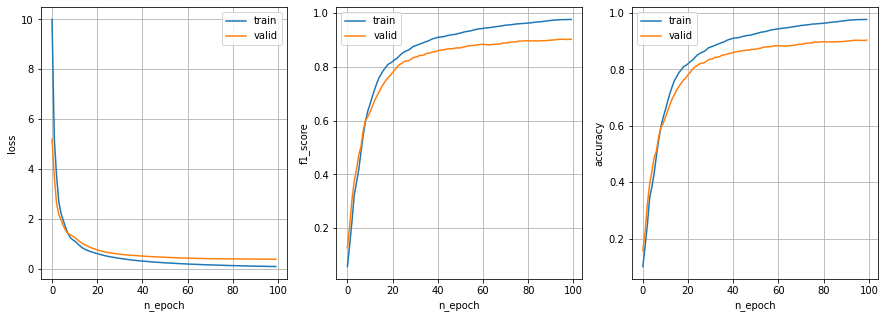

In [70]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [71]:
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.3793642520904541, f1: 0.7500945985022252, acc: 0.9030226469039917


# CASO 3: 50% DE LOS DATOS

In [72]:
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

test_files3 = test_files[0:496]

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files3)

In [73]:
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)))

N_test = len(test_files3)
X_test = []
Y_test = []

for i, test_file3 in enumerate(test_files3):
  Y_test.append( int(test_file3.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file3)) )

In [74]:
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

In [75]:
input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [76]:
n_epoch = 100

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

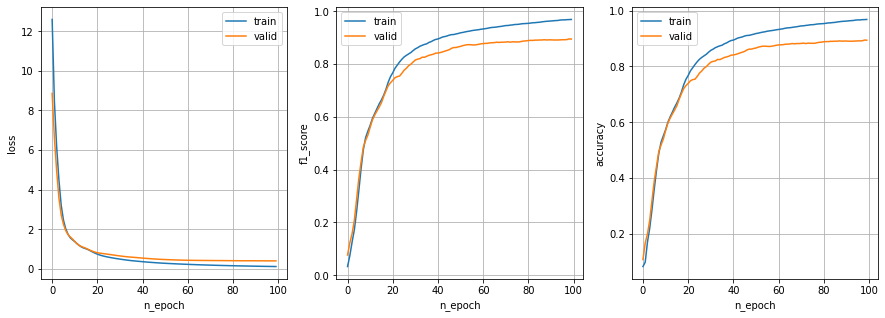

In [77]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [78]:
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.256705105304718, f1: 0.5226531277430394, acc: 0.9193548560142517


# CASO 4: 20% DE LOS DATOS

In [79]:
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

test_files4 = test_files[0:198]

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files4)

In [80]:
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)))

N_test = len(test_files4)
X_test = []
Y_test = []

for i, test_file4 in enumerate(test_files4):
  Y_test.append( int(test_file4.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file4)) )

In [81]:
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

In [82]:
input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [83]:
n_epoch = 100

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

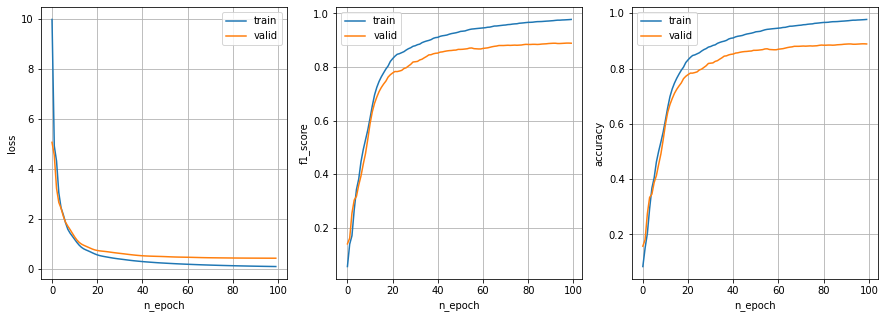

In [84]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [85]:
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.38846707344055176, f1: 0.2667535223673914, acc: 0.8838383555412292


# CASO 5: 10% DE LOS DATOS

In [86]:
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

test_files5 = test_files[0:99]

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files5)

In [87]:
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)))

N_test = len(test_files5)
X_test = []
Y_test = []

for i, test_file5 in enumerate(test_files5):
  Y_test.append( int(test_file5.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file5)) )

In [88]:
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

In [89]:
input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),  
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [90]:
n_epoch = 100

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)

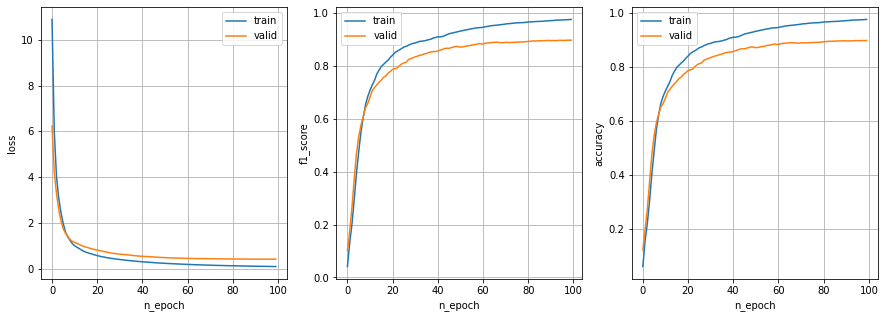

In [91]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [92]:
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.2947862446308136, f1: 0.15964912280701757, acc: 0.9191918969154358


## **ANÁLISIS**

De los resultados obtenidos para este caso, se puede afirmar que así se disminuyan los datos en el conjunto de datos de testeo, el algoritmo presenta un comportamiento aceptable con un accuracy mínimo, para el 10% de datos, de 0.9 aproximadamente. Esto puede deberse principalmente a que como el conjunto de entrenamiento y validación es amplio y es del 100%, la identificación que hace el algoritmo en los datos de testeo es adecuada ya que se encuentra preparado para hacerla. Sin embargo, la importancia en el tamaño en el conjunto de testeo radica en que es la evaluación para poder verificar el desempeño adecuado del algoritmo. De las gráficas obtenidas se puede decir que la brecha entre los datos de validación y entrenamiento es mucho menor que en el análisis hecho en el primer punto. Esto es un indicativo de la preparación del algoritmo para hacer la verificación de su funcionamiento con los datos del conjunto de testeo.